Download kaggle dataset to colab

In [ ]:
 ! pip install -q kaggle

In [ ]:
 from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"calistro","key":"6a04aa3a0434f4b66e8fcea16332a9e0"}'}

In [ ]:
 ! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d hlrhegemony/pokemon-image-dataset

 85% 49.0M/57.9M [00:00<00:00, 98.1MB/s]
100% 57.9M/57.9M [00:00<00:00, 129MB/s] 


In [ ]:
ls

kaggle.json  pokemon-image-dataset.zip  sample_data/


In [ ]:
! mkdir pokemon_dataset

In [ ]:
! unzip pokemon-image-dataset.zip -d pokemon_dataset

In [ ]:
ls

kaggle.json  pokemon_dataset/  pokemon-image-dataset.zip  sample_data/


Main code

Для решения задачи я буду использовать модель WGAN [https://arxiv.org/pdf/1701.07875.pdf] с gradient penalty [https://arxiv.org/pdf/1704.00028v3.pdf]. В качестве метрики качества использую FID (Frechet Inception Distance).

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torchvision

from torchvision.utils import make_grid
from torchvision import transforms
from torch.utils.data import DataLoader

import torchvision.models as models

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset

Буду обучать модель на изображениях размера 128 x 128, буду использовать аугментации RandomHorizontalFlip()

In [ ]:
image_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    torchvision.transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


Загружаю датасет, поделю его на train часть, и test, на тестовой части я буду считать метрику качества FID, для нее возьму немного картинок: 100, поскольку датасет в целом небольшой.

In [ ]:
pokemons_dataset = torchvision.datasets.ImageFolder(root='./pokemon_dataset',
                                   transform=image_transforms)

In [ ]:
batch_size = 20

indices_train, indices_test = train_test_split(list(range(len(pokemons_dataset))), test_size=100, random_state=29)

train_dataset = Subset(pokemons_dataset, indices=indices_train)
test_dataset = Subset(pokemons_dataset, indices=indices_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

Функция для обратной нормализации картинки в исходный range от 0 до 1

In [ ]:
def process_image(image):
    image = image.detach().to('cpu')
    # unnomalize image from [-1, 1] to [0, 1]
    image = (image + 1) / 2
    return image

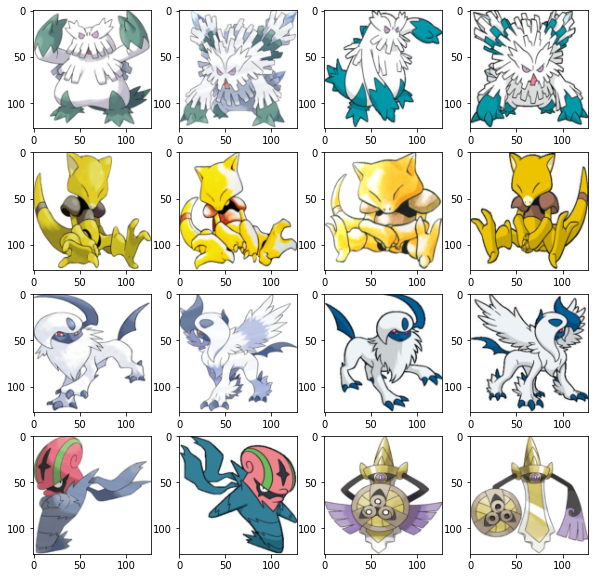

In [ ]:
plt.figure(figsize=(10, 10))
for ind, (image) in enumerate(pokemons_dataset):
    if ind >= 4*4: break
    plt.subplot(4, 4, ind+1)
    plt.imshow(process_image(image[0]).permute(1,2,0))
plt.show()

Функция для подсчета gradient_penalty, нужна для того, чтобы функция дискриминатора была липшицевой. Это помогает при обучении гана, улучшает сходимость.

In [ ]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.rand((real_samples.size(0), 1, 1, 1), device=device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    # Get gradient 
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones(real_samples.shape[0], requires_grad=False, device=device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

Функция для подсчета FID. Можно подробней почитать здесь : https://github.com/HSE-LAMBDA/DeepGenerativeModels/blob/spring-2021/seminars/seminar-2-metrics/metrics.ipynb


In [ ]:
import numpy as np
import torch
from scipy import linalg

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    diff = mu1 - mu2

    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)


def calculate_activation_statistics(dataloader, model, classifier):
    classifier.eval()
    model.eval()
    device = next(model.parameters()).device
    true_activations = []
    fake_activations = []
    for image, label in dataloader:
        z = torch.randn(imgs[0].shape[0], z_dim, device=device)        
        image = image.to(device)
        fake_image = model(z)
        true_activations.append(classifier(image).detach().cpu())
        fake_activations.append(classifier(fake_image).detach().cpu())
        
    m1 = np.mean(np.concatenate(true_activations), axis=0)
    m2 = np.mean(np.concatenate(fake_activations), axis=0)
    s1 = np.cov(np.concatenate(true_activations), rowvar=False)
    s2 = np.cov(np.concatenate(fake_activations), rowvar=False)
   
    return m1, s1, m2, s2
    

@torch.no_grad()
def calculate_fid(dataloader, model, classifier):
    
    m1, s1, m2, s2 = calculate_activation_statistics(dataloader, model, classifier)
    fid_value = calculate_frechet_distance(m1, s1, m2, s2)

    return fid_value.item()

Архитектура модели: генератор состоит из блоков: ConvTranspose, батчнорм, relu, каждый блок увеличивает картинку в 2 раза. На вход генератор получает шум размерности 100 из стандартного нормального распределения, первый блок преобразует шум в многоканальную картинку 4 x 4, следующие блоки увеличивают резмер картинки до 128 x 128.Дискриминатор (в wgan его также называют критик) состоит из блоков: свертка, instancenorm, leakyrelu, каждый блок уменьшает картинку в 2 раза, он берет на вход картинку и возвращает число - вероятность того, что картинка настоящая.

In [ ]:
class Generator(nn.Module):

    def __init__(self, in_dim, dim=32):
        super().__init__()

        def conv_bn_relu(in_dim, out_dim):
            return nn.Sequential(
                nn.ConvTranspose2d(in_dim, out_dim, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(out_dim),
                nn.ReLU())

        self.block1 = nn.Sequential(
            nn.Linear(in_dim, dim * 16 * 4 * 4, bias=False),
            nn.BatchNorm1d(dim * 16 * 4 * 4),
            nn.ReLU())
        self.block2 = nn.Sequential(
            conv_bn_relu(dim * 16, dim * 8),
            conv_bn_relu(dim * 8, dim * 4),
            conv_bn_relu(dim * 4, dim * 2),
            conv_bn_relu(dim * 2, dim),
            nn.ConvTranspose2d(dim, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh())

    def forward(self, x):
        y = self.block1(x)
        y = y.view(y.size(0), -1, 4, 4)
        y = self.block2(y)
        return y


class Discriminator(nn.Module):

    def __init__(self, in_dim, dim=32):
        super().__init__()

        def conv_in_lrelu(in_dim, out_dim):
            return nn.Sequential(
                nn.Conv2d(in_dim, out_dim, kernel_size=4, stride=2, padding=1),
                nn.InstanceNorm2d(out_dim),
                nn.LeakyReLU(0.2))

        self.block = nn.Sequential(
            nn.Conv2d(in_dim, dim, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            conv_in_lrelu(dim, dim * 2),
            conv_in_lrelu(dim * 2, dim * 4),
            conv_in_lrelu(dim * 4, dim * 8),
            conv_in_lrelu(dim * 8, dim * 16),
            nn.Conv2d(dim * 16, 1, 4))

    def forward(self, x):
        y = self.block(x)
        y = y.view(-1)
        return y

Я логирую в neptune лоссы для генератора, дискриминатора, каждую эпоху рисую сэмплируемые картинки, и каждые 5 эпох считаю FID. Финальный эксперимент можно посмотреть по ссылке https://app.neptune.ai/calistro/pokemons/e/POK-21. Если перейти по ссылке, то в папке logs будут batch_images (сгенерованные картинки), графики лоссов (D_loss, G_loss) и график FID.

In [ ]:
pip install neptune-client

In [ ]:
import neptune
NEPTUNE_API_TOKEN="sometoken"
neptune.init(f'calistro/pokemons', api_token=NEPTUNE_API_TOKEN)
neptune.create_experiment(name='wgan_FID_colab')

https://app.neptune.ai/calistro/pokemons/e/POK-21


Experiment(POK-21)

In [ ]:
device='cuda:0'
z_dim = 100
img_dim = 3

D = Discriminator(img_dim).to(device)
G = Generator(z_dim).to(device)

d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

Загружаю предобученный классификатор для подсчета FID (использую resnet вместо inception).


In [ ]:
trained_cls = models.resnet50(pretrained=True).to(device)
trained_cls.fc = nn.Identity()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Функция обучения, буду обучать 50 эпох:

In [ ]:
lambda_gp = 10
n_epochs = 50
n_critic = 5

with tqdm(total=n_epochs*len(train_loader), desc=f"[D loss: ?] [G loss: ?]") as pbar:

    for epoch in range(n_epochs):
        for i, imgs in enumerate(train_loader):
            G.train()
            real_imgs = imgs[0].to(device)

            #  train Discriminator
            d_optimizer.zero_grad()

            z = torch.randn(imgs[0].shape[0], z_dim, device=device)
          
            fake_imgs = G(z)
            real_validity = D(real_imgs)
            fake_validity = D(fake_imgs)
            gradient_penalty = compute_gradient_penalty(D, real_imgs.data, fake_imgs.data)
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty
            
            d_loss.backward()
            d_optimizer.step()

          # Train the generator every n_critic steps
            if i % n_critic == 0:
                g_optimizer.zero_grad()

                fake_imgs = G(z)
                fake_validity = D(fake_imgs)
                g_loss = -torch.mean(fake_validity)

                g_loss.backward()
                g_optimizer.step()
            
            neptune.log_metric('D loss', d_loss.item())
            neptune.log_metric('G loss', g_loss.item())
            pbar.set_description(f"[D loss: {d_loss.item():.2f}] [G loss: {g_loss.item():.2f}]")
            pbar.update(1)
        
        # calculate FID and log generated images
        G.eval()        
        if (epoch + 1) % 5 == 0:
            neptune.log_metric('FID', calculate_fid(test_loader, G, trained_cls))

        fig = plt.figure(figsize=(10,10))
        plt.imshow(make_grid(process_image(fake_imgs), nrow=4).detach().cpu().permute(1,2,0))
        plt.close(fig)
        neptune.log_image('batch_images', fig)
        

[D loss: ?] [G loss: ?]:   0%|          | 0/6000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Примеры сгенерированных картинок:

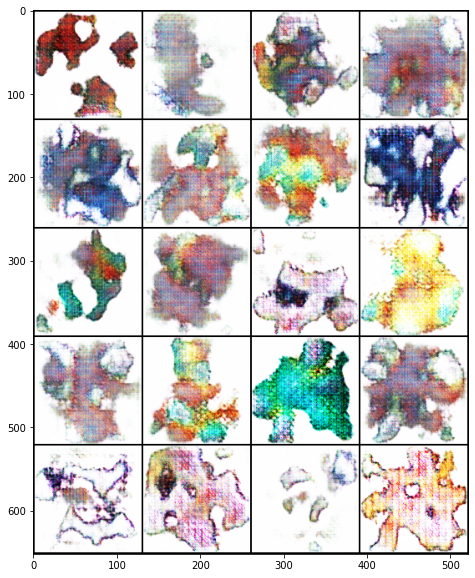

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(make_grid(process_image(fake_imgs), nrow=4).detach().cpu().permute(1,2,0))

Сохраняю обученный генератор сначала у себя на гугл драйв, чтобы потом перенести это в публичный гитхаб репозиторий, откуда его будет просто скачать

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
path = "/content/gdrive/MyDrive/pokemon_images_generator.pt"
torch.save(G, path)

Делаю инференс обученного генератора

In [ ]:
# load saved model from my public repository
! git clone 'https://github.com/jeniasivets/pokemon_generator'

Cloning into 'pokemon_generator'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.


In [ ]:
# define necessary functions and model interface for inference
import torch
from torch import nn
import matplotlib.pyplot as plt
from torchvision.utils import make_grid


def process_image(image):
    image = image.detach().to('cpu')
    # unnomalize image from [-1, 1] to [0, 1]
    image = (image + 1) / 2
    return image


class Generator(nn.Module):

    def __init__(self, in_dim, dim=32):
        super().__init__()

        def conv_bn_relu(in_dim, out_dim):
            return nn.Sequential(
                nn.ConvTranspose2d(in_dim, out_dim, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(out_dim),
                nn.ReLU())

        self.block1 = nn.Sequential(
            nn.Linear(in_dim, dim * 16 * 4 * 4, bias=False),
            nn.BatchNorm1d(dim * 16 * 4 * 4),
            nn.ReLU())
        self.block2 = nn.Sequential(
            conv_bn_relu(dim * 16, dim * 8),
            conv_bn_relu(dim * 8, dim * 4),
            conv_bn_relu(dim * 4, dim * 2),
            conv_bn_relu(dim * 2, dim),
            nn.ConvTranspose2d(dim, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh())

    def forward(self, x):
        y = self.block1(x)
        y = y.view(y.size(0), -1, 4, 4)
        y = self.block2(y)
        return y


In [ ]:
# load model on cpu
path ='pokemon_generator/pokemon_images_generator.pt'
model = torch.load(path, map_location={'cuda:0': 'cpu'})

In [ ]:
# generate images from noise
z = torch.randn(20, 100, device='cpu')
fake_imgs = model(z)

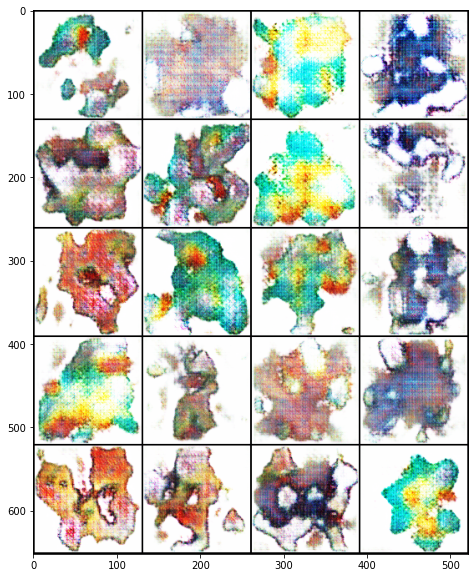

In [ ]:
# visualize generated images
plt.figure(figsize=(10,10))
plt.imshow(make_grid(process_image(fake_imgs), nrow=4).detach().cpu().permute(1,2,0))

Получили красивые разноцветные картинки. Для более правдоподобных результатов предположительно недостаточно времени на обучение.

Варианты других проведенных экспериментов: тестирование других архитектур для модели, смена параметров оптимизаторов, обучение классического гана без gradient penalty и с другими лоссами, обучение VAE; результаты значимо не улучшились.

P.S: поставила обучаться эту же модель на 100 эпох, результаты можно посмотреть по ссылке. Картинки стали более четкими, можно попробовать обучить еще дольше.

https://app.neptune.ai/calistro/pokemons2/e/POK1-1/all?path=logs&attribute=batch_images